In [1]:
%reset
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import scendict as sc
import utils as ut
import netCDF4 as nc
import xarray as xr
import numpy as np
from importlib import reload
reload(sc)
reload(ut)

import cartopy as cp
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import glob
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


#### open a multi-file dataset

In [2]:
#open tmesh
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['m2'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
lats = tmesh['nav_lat'][0:37,0]
yrs = np.arange(1980,2021,(1/12))

In [3]:
## carbon flux
ylist = ut.make_yearlist(1980,2020,'diad_T','TOM12_TJ_1AS1')
with xr.set_options(enable_cftimeindex=True):
    TJ_1AS1 = xr.open_mfdataset(ylist)
ylist = ut.make_yearlist(1980,2020,'diad_T','TOM12_TJ_1AW1')
with xr.set_options(enable_cftimeindex=True):
    TJ_1AW1 = xr.open_mfdataset(ylist)
w = nc.Dataset('../MO_pipeline/EXTRACT/ncs/scen_1A_monthly_wspd.nc')
wspd_1AS1 = w['mean_wspd'][40:81,0:12,:,:]

In [4]:
Cflx_1AS1 = TJ_1AS1.Cflx
Cflx_1AW1 = TJ_1AW1.Cflx

wspd_1AS1_hov = np.zeros_like(Cflx_1AS1.values)
ind = 0
for i in range(0,41):
    wspd_1AS1_hov[ind:ind+12,:,:] = wspd_1AS1[i,:,:]
    ind = ind+12
    
Cflx_1AS1_mmn = Cflx_1AS1.groupby('time_counter.month').mean('time_counter').values
Cflx_1AS1_mmn_b = np.zeros_like(Cflx_1AW1)
broadcast_m2 = np.zeros_like(Cflx_1AW1)
ind = 0
for i in range(0,41):
    Cflx_1AS1_mmn_b[ind:ind+12,:,:] = Cflx_1AS1_mmn
    ind = ind+12
for i in range(0,(41*12)):
    broadcast_m2[i,:,:] = tmesh['m2']

Cflx_1AS1_rlmn = Cflx_1AS1.rolling(time_counter=12, center=True).mean().values

In [5]:
print(np.shape(wspd_1AS1))
wspd_1AS1_month = np.nanmean(wspd_1AS1, axis = 0)
print(np.shape(wspd_1AS1_month))
print(np.shape(wspd_1AS1_hov))

wspd_1AS1_mmn_b = np.zeros_like(broadcast_m2)
ind = 0
for i in range(0,41):
    wspd_1AS1_mmn_b[ind:ind+12,:,:] = wspd_1AS1_month
    ind = ind+12
    
print(np.shape(wspd_1AS1_hov))
print(np.shape(wspd_1AS1_mmn_b))

(41, 12, 149, 182)
(12, 149, 182)
(492, 149, 182)
(492, 149, 182)
(492, 149, 182)


In [6]:
Cflx_1AS1v = TJ_1AS1.Cflx.values
Cflx_1AW1v = TJ_1AW1.Cflx.values
Cflx_1AS_min_W = Cflx_1AS1v-Cflx_1AW1v
Cflx_1AS1_rlmn_v = Cflx_1AS1_rlmn

Cflx_1AS1_mmn_b[broadcast_m2 == 0] = np.nan
Cflx_1AS1v[broadcast_m2 == 0] = np.nan
Cflx_1AW1v[broadcast_m2 == 0] = np.nan
Cflx_1AS_min_W[broadcast_m2 == 0] = np.nan
Cflx_1AS1_rlmn_v[broadcast_m2 == 0] = np.nan

wspd_1AS1_hov[broadcast_m2 == 0] = np.nan
wspd_1AS1_mmn_b[broadcast_m2 == 0] = np.nan


Cflx_1AS1_mmn_bl = np.nanmean(Cflx_1AS1_mmn_b, axis = 2)
Cflx_1AS1_bl = np.nanmean(Cflx_1AS1v, axis = 2)
Cflx_1AW1_bl = np.nanmean(Cflx_1AW1v, axis = 2)
Cflx_1AS_min_W_bl = np.nanmean(Cflx_1AS_min_W, axis = 2)
Cflx_1AS1_rlmn_bl = np.nanmean(Cflx_1AS1_rlmn_v, axis = 2)
wspd_1AS1_bl = np.nanmean(wspd_1AS1_hov, axis = 2)
wspd_1AS1_mmn_bl = np.nanmean(wspd_1AS1_mmn_b, axis = 2)

## examine windspeed anomalies

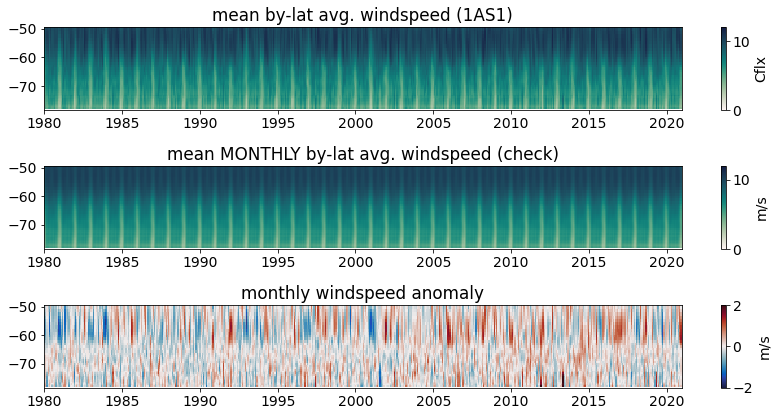

In [7]:
fact = 0.4
fig, axs = plt.subplots(3,1, figsize=(30*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
w = axs[0].pcolormesh(yrs, lats, np.transpose(wspd_1AS1_bl[:,0:37]), \
                  cmap = cm.cm.tempo, vmin = 0, vmax = 12)
fig.colorbar(w, ax = axs[0], label = 'Cflx')
axs[0].set_title('mean by-lat avg. windspeed (1AS1)') 

w = axs[1].pcolormesh(yrs, lats, np.transpose(wspd_1AS1_mmn_bl[:,0:37]), \
                  cmap = cm.cm.tempo, vmin = 0, vmax = 12)
fig.colorbar(w, ax = axs[1], label = 'm/s')
axs[1].set_title('mean MONTHLY by-lat avg. windspeed (check)')

wspd_1AS1_anom = wspd_1AS1_bl-wspd_1AS1_mmn_bl
w = axs[2].pcolormesh(yrs, lats, np.transpose(wspd_1AS1_anom[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -2, vmax = 2)
fig.colorbar(w, ax = axs[2], label = 'm/s')
axs[2].set_title('monthly windspeed anomaly')

plt.tight_layout()


## process 1AS1 cflx different ways and look at several types of anomalies

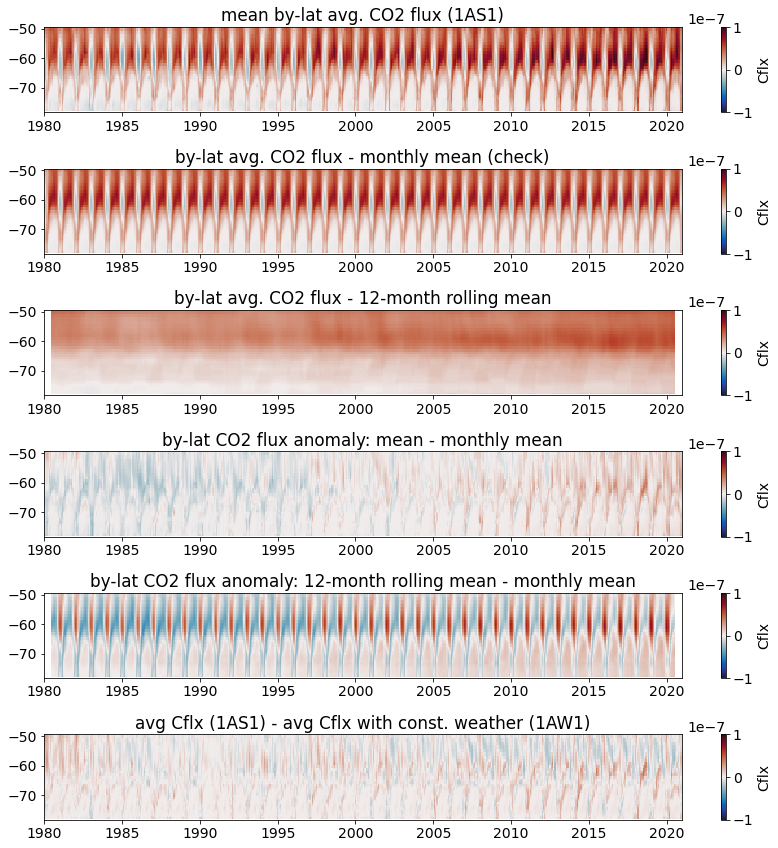

In [8]:
fact = 0.4
fig, axs = plt.subplots(6,1, figsize=(30*fact, 30*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
w = axs[0].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_bl[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -1e-7, vmax = 1e-7)
fig.colorbar(w, ax = axs[0], label = 'Cflx')
axs[0].set_title('mean by-lat avg. CO2 flux (1AS1)') 

w = axs[1].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_mmn_bl[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -1e-7, vmax = 1e-7)
fig.colorbar(w, ax = axs[1], label = 'Cflx')
axs[1].set_title('by-lat avg. CO2 flux - monthly mean (check)')

w = axs[2].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_rlmn_bl[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -1e-7, vmax = 1e-7)
fig.colorbar(w, ax = axs[2], label = 'Cflx')
axs[2].set_title('by-lat avg. CO2 flux - 12-month rolling mean')

Cflx_1AS1_anom = Cflx_1AS1_bl-Cflx_1AS1_mmn_bl
w = axs[3].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_anom[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -1e-7, vmax = 1e-7)
axs[3].set_title('by-lat CO2 flux anomaly: mean - monthly mean')
fig.colorbar(w, ax = axs[3], label = 'Cflx')

Cflx_1AS1_anom_roll = Cflx_1AS1_rlmn_bl-Cflx_1AS1_mmn_bl
w = axs[4].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_anom_roll[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -1e-7, vmax = 1e-7)
axs[4].set_title('by-lat CO2 flux anomaly: 12-month rolling mean - monthly mean')
fig.colorbar(w, ax = axs[4], label = 'Cflx')

w = axs[5].pcolormesh(yrs, lats, np.transpose(Cflx_1AS_min_W_bl[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -1e-7, vmax = 1e-7)
axs[5].set_title('avg Cflx (1AS1) - avg Cflx with const. weather (1AW1)')
fig.colorbar(w, ax = axs[5], label = 'Cflx')
plt.tight_layout()

## together - no abs value on Cflx anomaly

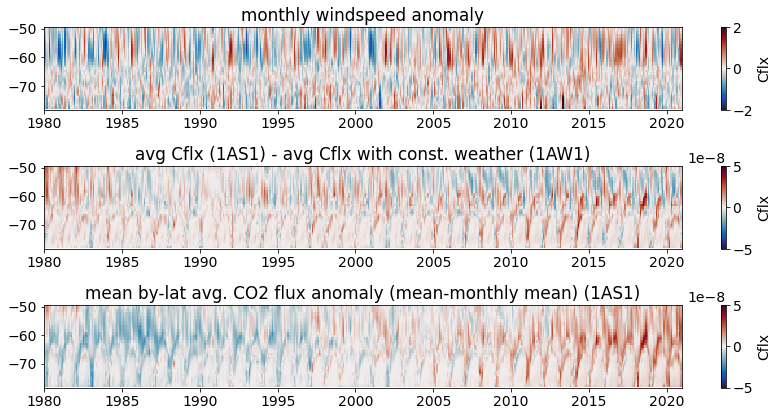

In [9]:
## 
fact = 0.4
fig, axs = plt.subplots(3,1, figsize=(30*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
w = axs[0].pcolormesh(yrs, lats, np.transpose(wspd_1AS1_anom[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -2, vmax = 2 )
fig.colorbar(w, ax = axs[0], label = 'Cflx')
axs[0].set_title('monthly windspeed anomaly') 



w = axs[1].pcolormesh(yrs, lats, np.transpose(Cflx_1AS_min_W_bl[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -5e-8, vmax =  5e-8)
fig.colorbar(w, ax = axs[1], label = 'Cflx')
axs[1].set_title('avg Cflx (1AS1) - avg Cflx with const. weather (1AW1)') 

w = axs[2].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_anom[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -5e-8, vmax =  5e-8)
fig.colorbar(w, ax = axs[2], label = 'Cflx')
axs[2].set_title('mean by-lat avg. CO2 flux anomaly (mean-monthly mean) (1AS1)') 
plt.tight_layout()
# wspd_1AS1_anom
# Cflx_1AS1_anom
# Cflx_1AS_min_W_bl

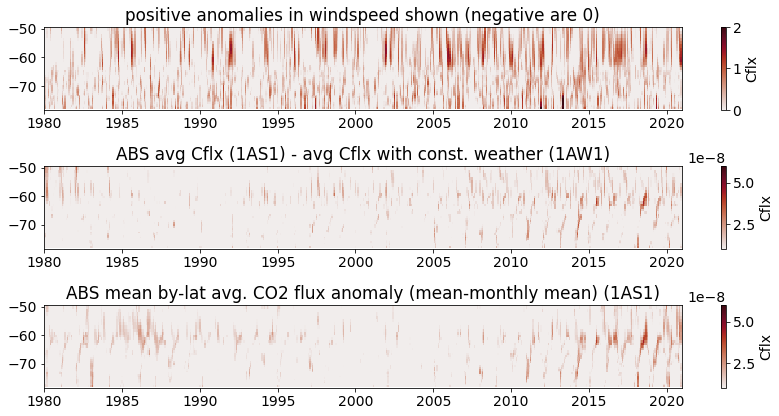

In [10]:
## 
fact = 0.4
fig, axs = plt.subplots(3,1, figsize=(30*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
wspd_1AS1_anom_abs = np.copy(wspd_1AS1_anom)
wspd_1AS1_anom_abs[wspd_1AS1_anom_abs<0]=0
w = axs[0].pcolormesh(yrs, lats, np.transpose(wspd_1AS1_anom[:,0:37]), \
                  cmap = cm.cm.amp, vmin = 0, vmax = 2 )
fig.colorbar(w, ax = axs[0], label = 'Cflx')
axs[0].set_title('positive anomalies in windspeed shown (negative are 0)') 


Cflx_1AS_min_W_bl_abs = np.abs(Cflx_1AS_min_W_bl)
w = axs[1].pcolormesh(yrs, lats, np.transpose(Cflx_1AS_min_W_bl_abs[:,0:37]), \
                  cmap = cm.cm.amp, vmin = 1e-8, vmax =  6e-8)
fig.colorbar(w, ax = axs[1], label = 'Cflx')
axs[1].set_title('ABS avg Cflx (1AS1) - avg Cflx with const. weather (1AW1)') 

Cflx_1AS1_anom_abs = np.abs(Cflx_1AS1_anom)
w = axs[2].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_anom_abs[:,0:37]), \
                  cmap = cm.cm.amp, vmin = 1e-8, vmax =  6e-8)
fig.colorbar(w, ax = axs[2], label = 'Cflx')
axs[2].set_title('ABS mean by-lat avg. CO2 flux anomaly (mean-monthly mean) (1AS1)') 
plt.tight_layout()
# wspd_1AS1_anom
# Cflx_1AS1_anom
# Cflx_1AS_min_W_bl

In [11]:
w = nc.Dataset('../MO_pipeline/EXTRACT/ncs/scen_1A_monthly_wspd.nc')
wspd_1AS1 = w['mean_wspd'][40:81,0:12,:,:]
wspd_1AS1_hov = np.zeros_like(Cflx_1AS1.values)
ind = 0
for i in range(0,51):
    wspd_1AS1_hov[ind:ind+12,:,:] = wspd_1AS1[i,:,:]
    ind = ind+12


IndexError: index 41 is out of bounds for axis 0 with size 41

In [ ]:
#rolling mean
Cflx_1AS1_rlmn = Cflx_1AS1.rolling(time_counter=12, center=True).mean().values
#monthly mean
Cflx_1AS1_mmn = Cflx_1AS1.groupby('time_counter.month').mean('time_counter').values
    
### broadcasting
Cflx_1AS1_mmn_b = np.zeros_like(Cflx_1AS1_rlmn)
broadcast_m2 = np.zeros_like(Cflx_1AS1_rlmn)
for i in range(0,60):
    Cflx_1AS1_mmn_b[i:i+12,:,:] = Cflx_1AS1_mmn
    i = i+12

for i in range(0,612):
    broadcast_m2[i,:,:] = tmesh['m2']
    
Cflx_1AS1_anom = Cflx_1AS1-Cflx_1AS1_rlmn-Cflx_1AS1_mmn_b
Cflx_1AS1_anom = Cflx_1AS1_anom.values
Cflx_1AS1_anom[broadcast_m2 == 0] = np.nan
Cflx_1AS1_min_1AW1 = Cflx_1AS1-Cflx_1AW1
wspd_1AS1_hov[broadcast_m2 == 0] = np.nan

In [ ]:
#bylat 
Cflx_1AS1_bylat = np.nanmean(Cflx_1AS1,axis = 2)
# print(np.shape(Cflx_1AS1_bylat))
Cflx_1AS1_anom_bylat = np.nanmean(Cflx_1AS1_anom,axis = 2)
Cflx_1AS1_min_1AW1_bylat = np.nanmean(Cflx_1AS1_min_1AW1, axis = 2)
wspd_1AS1_hov_bylat = np.nanmean(wspd_1AS1_hov, axis = 2)

In [ ]:
lats = tmesh['nav_lat'][0:37,0]
yrs = np.arange(1990,2021,(1/12))

fact = 0.8
fig, axs = plt.subplots(3,2, figsize=(20*fact, 14*fact),\
                        facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolormesh(yrs, lats, np.transpose(wspd_1AS1_hov_bylat[:,0:37]), \
                  cmap = cm.cm.tempo, vmin = 4, vmax = 12)
fig.colorbar(w, ax=axs[0], orientation = 'horizontal', label = 'm/s')

w = axs[2].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_bylat[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -1e-7, vmax = 1e-7)
fig.colorbar(w, ax=axs[2], orientation = 'horizontal', label = 'mol/m2/s')

w = axs[3].pcolormesh(yrs, lats, np.transpose(Cflx_1AS1_anom_bylat[:,0:37]), \
                  cmap = cm.cm.balance, vmin = -1e-7, vmax = 1e-7)
fig.colorbar(w, ax=axs[3], orientation = 'horizontal', label = 'mol/m2/s')

In [ ]:
print(np.shape(Cflx_1AW1))
print(732/12)

## rolling mean!

In [ ]:
# Cflx_1AS1 = Cflx_1AS1.assign_coords(year_month=Cflx_1AS1.time_counter.dt.strftime("%Y-%m"))
# result = Cflx_1AS1.groupby("year_month") - Cflx_1AS1.groupby("year_month").mean("time_counter")


In [ ]:
#rolling mean
Cflx_1AS1_rlmn = Cflx_1AS1.rolling(time_counter=12, center=True).mean().values
#monthly mean
Cflx_1AS1_mmn = Cflx_1AS1.groupby('time_counter.month').mean('time_counter').values
    
### broadcasting
Cflx_1AS1_mmn_b = np.zeros_like(Cflx_1AS1_rlmn)
broadcast_m2 = np.zeros_like(Cflx_1AS1_rlmn)
for i in range(0,60):
    Cflx_1AS1_mmn_b[i:i+12,:,:] = Cflx_1AS1_mmn
    i = i+12

for i in range(0,612):
    broadcast_m2[i,:,:] = tmesh['m2']
    
Cflx_1AS1_anom = Cflx_1AS1-Cflx_1AS1_rlmn-Cflx_1AS1_mmn_b
Cflx_1AS1_anom = Cflx_1AS1_anom.values
Cflx_1AS1_min_1AW1 = Cflx_1AS1-Cflx_1AW1
Cflx_1AS1_anom[broadcast_m2 == 0] = np.nan


In [ ]:
Cflx_1AS1_anom = Cflx_1AS1_anom.weighted(broadcast_m2_xr)

In [ ]:
Cflx_1AS1_anom.mean(axis = 2)

In [ ]:
Cflx_1AS1_mmn_b = np.zeros_like(Cflx_1AS1_rlmn)
broadcast_m2 = np.zeros_like(Cflx_1AS1_rlmn)
for i in range(0,60):
    Cflx_1AS1_mmn_b[i:i+12,:,:] = Cflx_1AS1_mmn
    i = i+12

for i in range(0,612):
    broadcast_m2[i,:,:] = tmesh['m2']

In [ ]:
#rolling mean
Cflx_1AS1_rlmn = Cflx_1AS1.rolling(time_counter=12, center=True).mean()
#monthly mean
Cflx_1AS1_mmn = Cflx_1AS1.groupby('time_counter.month').mean('time_counter')
detrend = Cflx_1AS1 - Cflx_1AS1_rlmn
print(detrend)
Cflx_1AS1_anom = detrend.groupby('time_counter.month').mean('time_counter')-Cflx_1AS1_mmn

In [ ]:
Cflx_1AS1_anom

In [ ]:
Cflx_1AS1_anom = Cflx_1AS1 - Cflx_1AS1_rlmn - Cflx_1AS1_mmn

climatology = Cflx_1AS1.groupby("time_counter.month").mean("time_counter")
anomalies = Cflx_1AS1.groupby("time_counter.month")  - climatology

In [ ]:
Cflx_1AS1_anom

In [ ]:
w = nc.Dataset('../MO_pipeline/EXTRACT/ncs/scen_1A_monthly_wspd.nc')
wspd_1AS1 = w['mean_wspd'][20:80,0:12,0:37,:]


#### add another array to the dataset based on previous attributes

#### some operations on cflx - annual totals? 

In [ ]:
#monthly means
sid = 60*24*24
Cflx = ds.Cflx
Cflx_mol_day = ds.Cflx * sid * tmesh.m2
Cflx

Cflx_monthly = Cflx.groupby('time_counter.month').mean('time_counter')

#mean february
febmean = Cflx_monthly.sel(month=2)
type(febmean)

In [ ]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

month_length = xr.DataArray(get_dpm(Cflx_1AS1.time_counter.to_index(),
                                      calendar='noleap'),
                              coords=[Cflx_1AS1.time_counter], name='month_length')